In [34]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix

In [35]:
# Image size and base path for dataset
pic_size = 48
base_path = "../input/face-expression-recognition-dataset/images/"
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
num_classes = len(emotion_labels)

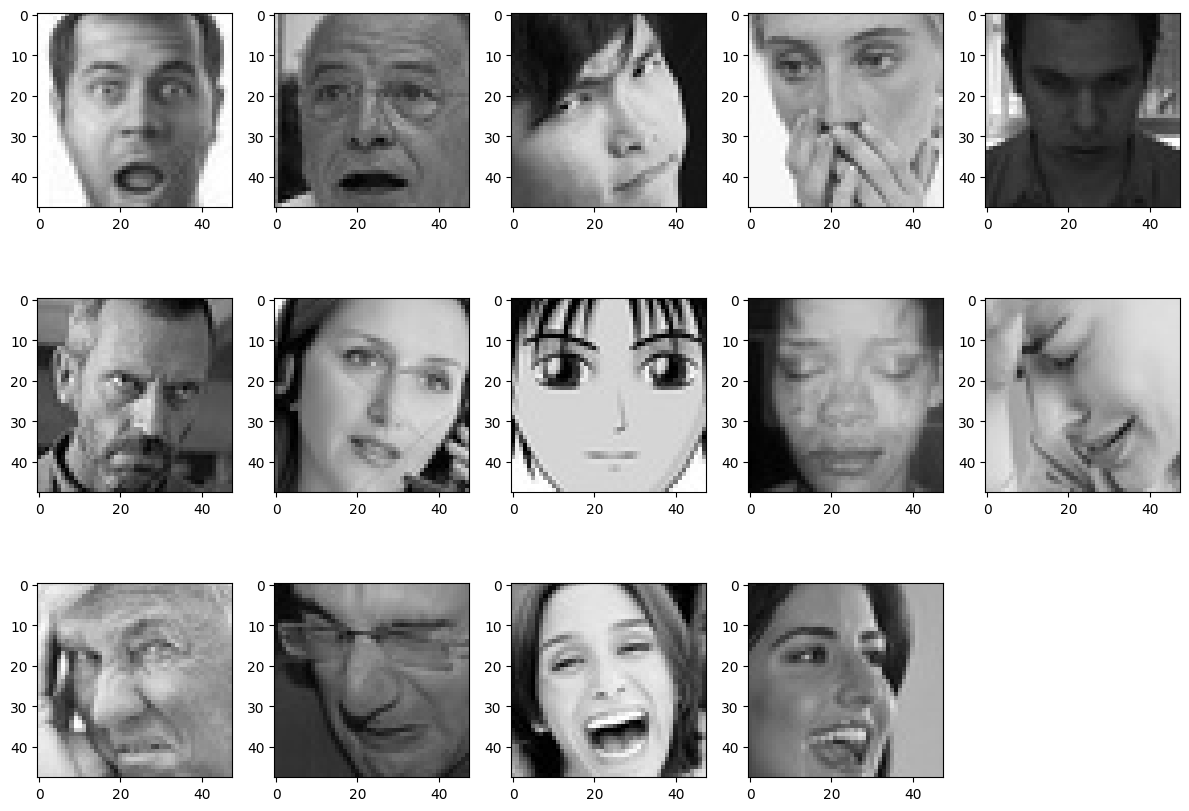

In [36]:
# Size of the image: 48*48 pixels
pic_size = 48

# Input path for the images
base_path = "../input/face-expression-recognition-dataset/images/"

plt.figure(0, figsize=(12,20))
cpt = 0

for expression in os.listdir(base_path + "train"):
    for i in range(1,3):
        cpt = cpt + 1
        plt.subplot(7,5,cpt)
        img = load_img(base_path + "train/" + expression + "/" +os.listdir(base_path 
                              + "train/" + expression)[i], target_size=(pic_size, pic_size))
        plt.imshow(img, cmap="gray")

plt.tight_layout()
plt.show()

In [37]:
# Emotion labels
emotion_labels = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Function to count the number of images in each subfolder
def count_images_in_folder(folder_path):
    image_counts = {}
    for label in emotion_labels:
        image_folder = os.path.join(folder_path, label)
        num_images = len(os.listdir(image_folder))
        image_counts[label] = num_images
    return image_counts

# Count the number of images in the train and validation folders
train_image_counts = count_images_in_folder(os.path.join(base_path, 'train'))
validation_image_counts = count_images_in_folder(os.path.join(base_path, 'validation'))

# Print the number of images
print("Number of images in the train folder:")
print(train_image_counts)
print("\nNumber of images in the validation folder:")
print(validation_image_counts)

Number of images in the train folder:
{'angry': 3993, 'disgust': 436, 'fear': 4103, 'happy': 7164, 'neutral': 4982, 'sad': 4938, 'surprise': 3205}

Number of images in the validation folder:
{'angry': 960, 'disgust': 111, 'fear': 1018, 'happy': 1825, 'neutral': 1216, 'sad': 1139, 'surprise': 797}


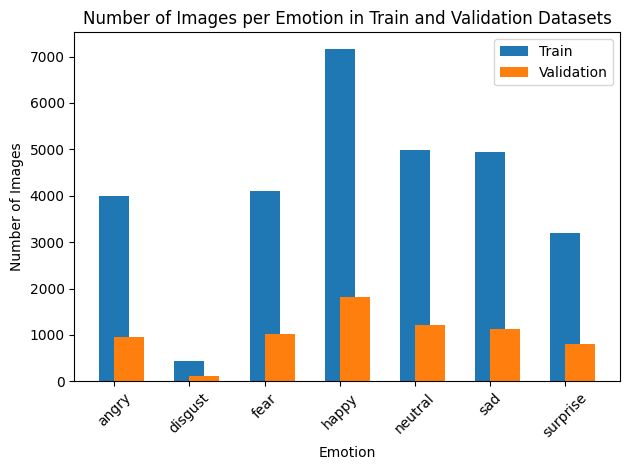

In [38]:
# Plot bar chart
def plot_image_counts(train_counts, validation_counts):
    labels = list(train_counts.keys())
    train_values = list(train_counts.values())
    validation_values = list(validation_counts.values())

    x = range(len(labels))

    fig, ax = plt.subplots()
    ax.bar(x, train_values, width=0.4, label='Train', align='center')
    ax.bar(x, validation_values, width=0.4, label='Validation', align='edge')

    ax.set_xlabel('Emotion')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images per Emotion in Train and Validation Datasets')
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_image_counts(train_image_counts, validation_image_counts)

In [39]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Load and preprocess the training and validation data
batch_size = 128
train_generator = train_datagen.flow_from_directory(
    base_path + "train",
    target_size=(pic_size, pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    base_path + "validation",
    target_size=(pic_size, pic_size),
    color_mode="grayscale",
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [40]:
# Define the CNN model architecture
model = Sequential([
    Conv2D(64, (3, 3), padding='same', input_shape=(pic_size, pic_size, 1)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (5, 5), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),

    Dense(256),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(512),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.25),

    Dense(num_classes, activation='softmax')
])

# Compile the model with class weights
opt = Adam(learning_rate=0.0001)
class_weights = {
    0: 1.0,  # angry
    1: 1.75,  # disgust
    2: 1.5,  # fear
    3: 1.0,  # happy
    4: 1.0,  # neutral
    5: 1.25,  # sad
    6: 1.0   # surprise
}
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [41]:
# Define callbacks
checkpoint = ModelCheckpoint("best_model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

# Train the model
epochs = 50
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.n // validation_generator.batch_size,
    class_weight=class_weights,
    callbacks=[checkpoint]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/225 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.1289 - loss: 2.6747   

W0000 00:00:1717353154.629061     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


165/225 ━━━━━━━━━━━━━━━━━━━━ 14s 246ms/step - accuracy: 0.1775 - loss: 2.4855

W0000 00:00:1717353194.835260     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.1847 - loss: 2.4501

W0000 00:00:1717353206.324930     125 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.16179, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 78s 277ms/step - accuracy: 0.1848 - loss: 2.4496 - val_accuracy: 0.1618 - val_loss: 1.9165
Epoch 2/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.2344 - loss: 2.2045

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)



Epoch 2: val_accuracy did not improve from 0.16179
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.2344 - loss: 2.2045 - val_accuracy: 0.0000e+00 - val_loss: 3.4953
Epoch 3/50


W0000 00:00:1717353217.233292     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


216/225 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - accuracy: 0.2293 - loss: 2.2107
Epoch 3: val_accuracy improved from 0.16179 to 0.27599, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.2296 - loss: 2.2096 - val_accuracy: 0.2760 - val_loss: 1.8807
Epoch 4/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 70ms/step - accuracy: 0.2031 - loss: 2.1551
Epoch 4: val_accuracy did not improve from 0.27599
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - accuracy: 0.2031 - loss: 2.1551 - val_accuracy: 0.0000e+00 - val_loss: 3.6164
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.2462 - loss: 2.1383
Epoch 5: val_accuracy improved from 0.27599 to 0.29787, saving model to best_model.keras
225/225 ━━━━━━━━━━━━━━━━━━━━ 42s 181ms/step - accuracy: 0.2462 - loss: 2.1382 - val_accuracy: 0.2979 - val_loss: 1.8104
Epoch 6/50
  1/225 ━━━━━━━━━━━━━━━━━━━━ 15s 68ms/step - accuracy: 0.3047 - loss: 2.0185
Epoch 6: val_accuracy did not improve from 0.29787
225/225 ━━━━━━━━━

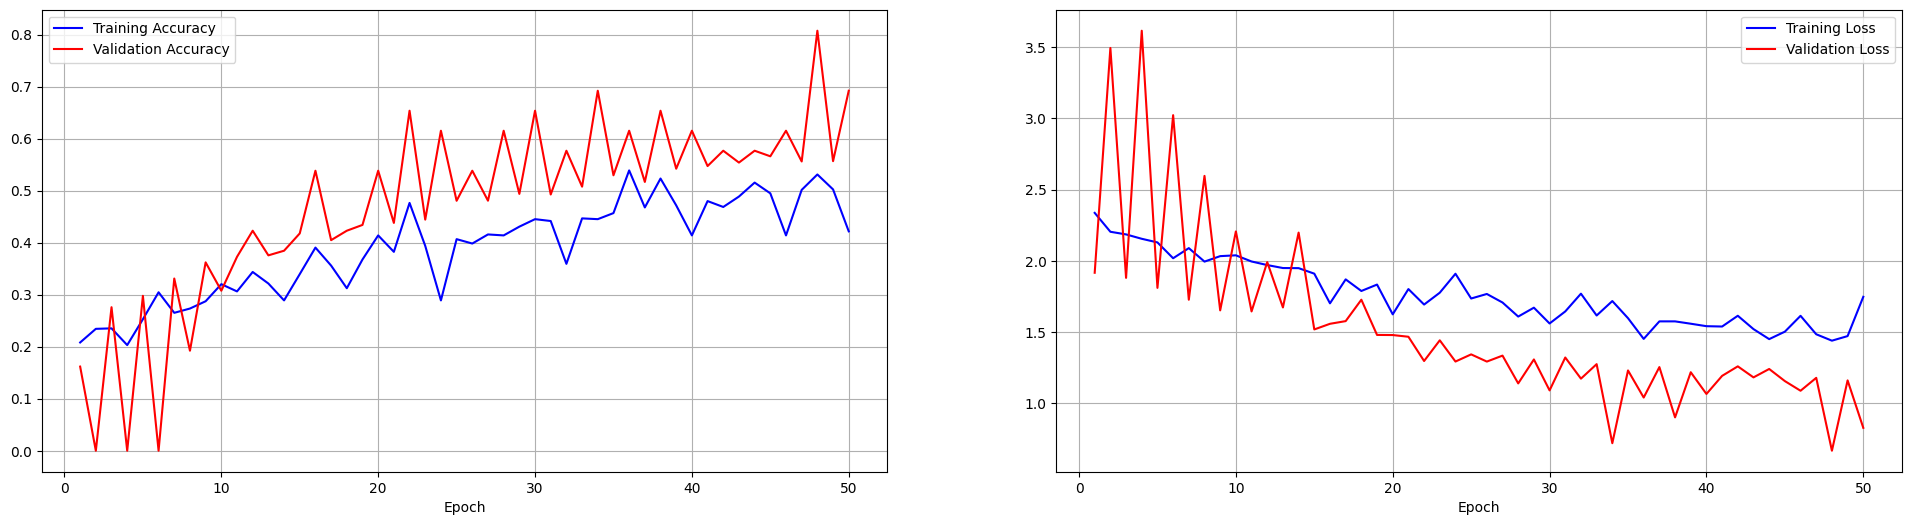

In [42]:
# Visualize training and testing accuracy and loss
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()

plot_results(history)

In [43]:
# Get best epoch with best accuracy on validation
def get_best_epoch(history):
    valid_acc = history.history['val_accuracy']
    best_epoch = valid_acc.index(max(valid_acc)) + 1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format(best_acc, best_epoch))
    return best_epoch

best_epoch = get_best_epoch(history)

Best Validation Accuracy Score 0.80769, is for epoch 48


 3/56 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step  

W0000 00:00:1717354247.037273     123 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step


W0000 00:00:1717354253.204293     124 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

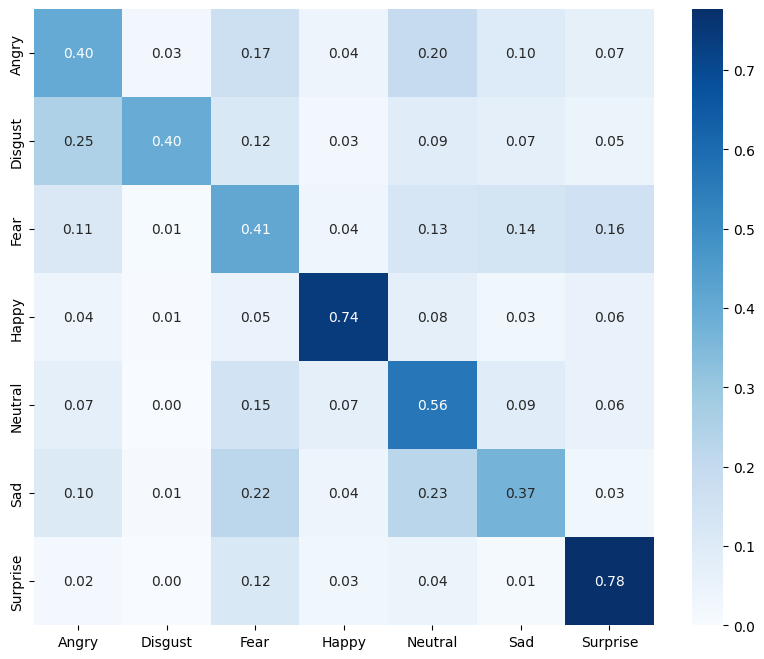

In [44]:
# Load the best saved model
best_model = load_model("best_model.keras")

# Generate predictions
Y_true = validation_generator.classes
Y_pred = best_model.predict(validation_generator, steps=validation_generator.n // validation_generator.batch_size + 1)
Y_pred_classes = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(Y_true, Y_pred_classes)
conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot the normalized confusion matrix
labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_norm, annot=True, fmt=".2f", xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.ylabel